In [1]:
##pytorch computer vision
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


In [2]:
##getting data minist
train_data=datasets.FashionMNIST(root='data',train=True,download=True,transform=torchvision.transforms.ToTensor(),target_transform=None)
test_data=datasets.FashionMNIST(root='data',train=False,download=True,transform=torchvision.transforms.ToTensor(),target_transform=None)

100%|██████████| 26421880/26421880 [00:04<00:00, 5648457.19it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 370427.09it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5982009.79it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14039191.80it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(train_data),len(test_data)

(60000, 10000)

In [4]:
class_names=train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
class_to_idx=train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
image,label=train_data[0]
image.shape,label

(torch.Size([1, 28, 28]), 9)

(-0.5, 27.5, 27.5, -0.5)

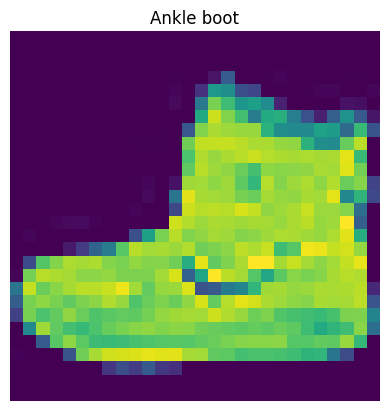

In [7]:
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)


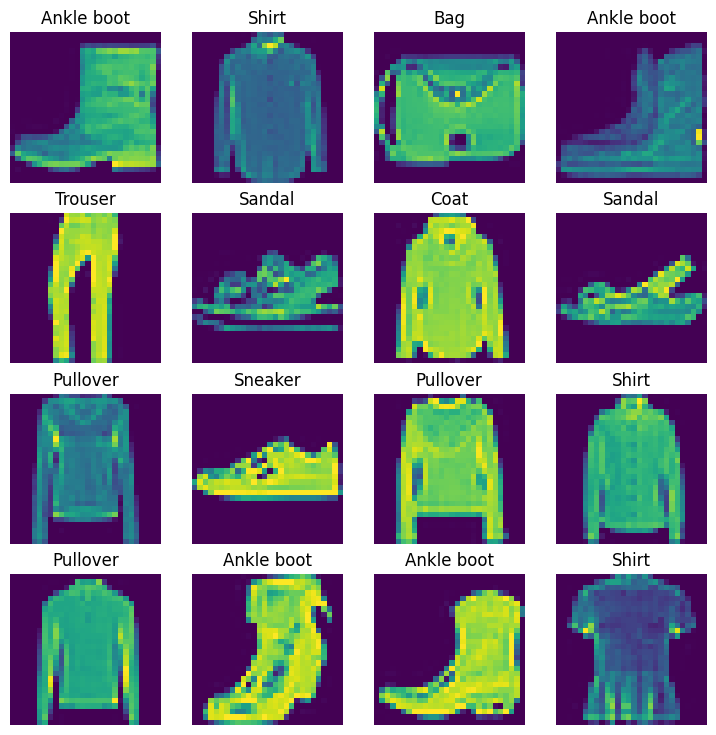

In [8]:
torch.manual_seed(42)
fig=plt.figure(figsize=(9,9))
rows,cols=4,4
for i in range(1,rows*cols+1):
    random_idx=torch.randint(0,len(train_data),size=[1]).item()
    image,label=train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(image.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

In [9]:
##Prepare data loader
from torch.utils.data import DataLoader
train_dataloader=DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=32,shuffle=False)

In [10]:
train_dataloader

In [11]:
print(f'Length:{len(train_dataloader)},len:{len(test_dataloader)}')

Length:1875,len:313


In [12]:
train_features_batch,train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

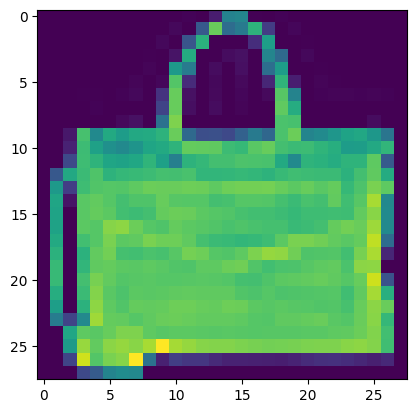

In [13]:
#torch.manual_seed(42)
random_idx=torch.randint(0,len(train_features_batch),size=[1]).item()
image=train_features_batch[random_idx]
label=train_labels_batch[random_idx]
plt.imshow(image.squeeze())

In [14]:
flatten_model=nn.Flatten()
x=train_features_batch[0]
output=flatten_model(x)
x.shape,output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [15]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,input_shape,hidden_units,output_shape):
    super().__init__()
    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_shape)
    )
  def forward(self,x):
    return self.layer_stack(x)
model_1=FashionMNISTModelV1(input_shape=784,hidden_units=10,output_shape=len(class_names))
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
dummy=torch.rand([1,28,28])
model_1(dummy)

tensor([[-0.5382, -0.2103, -0.1958, -0.2007,  0.4601, -0.1884,  0.1586,  0.2547,
         -0.3227, -0.3623]], grad_fn=<AddmmBackward0>)

In [17]:
from pathlib import Path
import requests
if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists")
else:
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  print("helper_functions.py downloaded")
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

helper_functions.py downloaded


In [18]:
from helper_functions import accuracy_fn,plot_loss_curves
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [19]:
%%time
from tqdm.auto import tqdm
epochs=3
for epoch in tqdm(range(epochs)):
  print(f'Epoch:{epoch+1}')
  train_loss=0
  train_acc=0
  for batch,(x,y) in enumerate(train_dataloader):
    model_1.train()
    y_pred=model_1(x)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch%400==0:
      print(f'Looked at {batch*len(x)}/{len(train_dataloader.dataset)} samples')
  train_loss/=len(train_dataloader)
  test_loss,test_acc=0,0
  for x,y in test_dataloader:
      test_pred=model_1(x)
      test_loss+=loss_fn(test_pred,y)
      test_acc+=accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
  test_loss/=len(test_dataloader)
  test_acc/=len(test_dataloader)
  print(f'Train loss:{train_loss:.5f} | Test loss:{test_loss:.5f} | Test acc:{test_acc:.2f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.59096 | Test loss:0.51285 | Test acc:82.13
Epoch:2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.47624 | Test loss:0.47996 | Test acc:82.99
Epoch:3
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.45408 | Test loss:0.48461 | Test acc:82.85
CPU times: user 39.6 s, sys: 511 ms, total: 40.1 s
Wall time: 1min 3s


In [20]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [21]:
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4846091866493225,
 'model_acc': 82.84744408945687}

In [22]:
## Build model using non-linearity
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU()
    )
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [23]:
model_2=FashionMNISTModelV2(input_shape=784,hidden_units=10,output_shape=len(class_names))
model_2

FashionMNISTModelV2(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [24]:
%%time
from helper_functions import accuracy_fn,plot_loss_curves
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.1)
from tqdm.auto import tqdm
epochs=3
for epoch in tqdm(range(epochs)):
  print(f'Epoch:{epoch+1}')
  train_loss=0
  train_acc=0
  for batch,(x,y) in enumerate(train_dataloader):
    model_2.train()
    y_pred=model_2(x)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch%400==0:
      print(f'Looked at {batch*len(x)}/{len(train_dataloader.dataset)} samples')
  train_loss/=len(train_dataloader)
  test_loss,test_acc=0,0
  for x,y in test_dataloader:
      test_pred=model_2(x)
      test_loss+=loss_fn(test_pred,y)
      test_acc+=accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
  test_loss/=len(test_dataloader)
  test_acc/=len(test_dataloader)
  print(f'Train loss:{train_loss:.5f} | Test loss:{test_loss:.5f} | Test acc:{test_acc:.2f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.91224 | Test loss:0.74007 | Test acc:73.02
Epoch:2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.64263 | Test loss:0.48250 | Test acc:82.99
Epoch:3
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.45745 | Test loss:0.46417 | Test acc:83.39
CPU times: user 38.3 s, sys: 143 ms, total: 38.5 s
Wall time: 44.9 s


In [25]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [26]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.4641698896884918,
 'model_acc': 83.38658146964856}

In [27]:
model_1_results=eval_model(model=model_1,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
model_2_results=eval_model(model=model_2,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [28]:
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4846091866493225,
 'model_acc': 82.84744408945687}

In [29]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.4641698896884918,
 'model_acc': 83.38658146964856}

In [35]:
#Build a CNN network
class FashionMNISTModelV3(nn.Module):
  def __init__(self,input_shape,hidden_units,output_shape):
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,out_features=output_shape))
  def forward(self,x):
      x=self.conv_block_1(x)
      x=self.conv_block_2(x)
      x=self.classifier(x)
      return x


In [36]:
model_3=FashionMNISTModelV3(input_shape=1,hidden_units=10,output_shape=len(class_names))
model_3

FashionMNISTModelV3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [37]:
#loss function and optimizer
from helper_functions import accuracy_fn
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_3.parameters(),lr=0.1)


In [38]:
%%time
torch.manual_seed(42)

epoch=3
for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch+1}")
  train_loss=0
  train_acc=0
  for batch,(x,y) in enumerate(train_dataloader):
    model_3.train()
    y_pred=model_3(x)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch%400==0:
      print(f'Looked at {batch*len(x)}/{len(train_dataloader.dataset)} samples')
  train_loss/=len(train_dataloader)
  test_loss,test_acc=0,0
  for x,y in test_dataloader:
      test_pred=model_3(x)
      test_loss+=loss_fn(test_pred,y)
      test_acc+=accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
  test_loss/=len(test_dataloader)
  test_acc/=len(test_dataloader)
  print(f'Train loss:{train_loss:.5f} | Test loss:{test_loss:.5f} | Test acc:{test_acc:.2f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.68383 | Test loss:0.39123 | Test acc:86.15
Epoch:2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.36017 | Test loss:0.34789 | Test acc:87.38
Epoch:3
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.32436 | Test loss:0.32361 | Test acc:88.41
CPU times: user 2min 26s, sys: 916 ms, total: 2min 27s
Wall time: 2min 34s


In [39]:
model_3_results=eval_model(model=model_3,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [41]:
import pandas as pd
compare_results=pd.DataFrame([model_1_results,model_2_results,model_3_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV1,0.484609,82.847444
1,FashionMNISTModelV2,0.464170,83.386581
2,FashionMNISTModelV3,0.323611,88.408546


Text(0.5, 1.0, 'Model accuracy comparison')

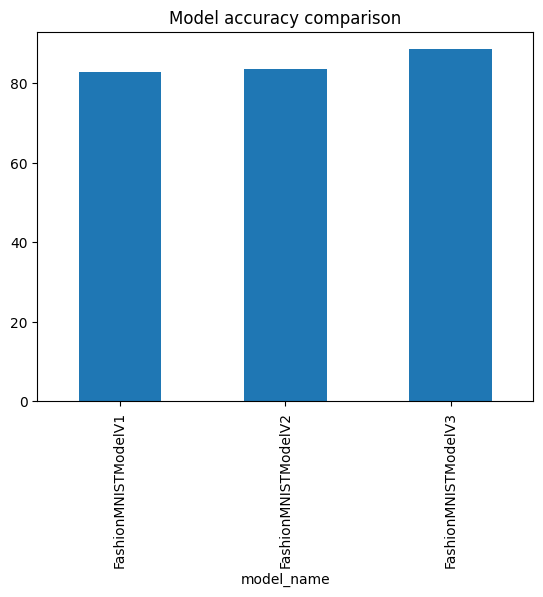

In [42]:
compare_results.set_index('model_name')['model_acc'].plot(kind='bar')
plt.title('Model accuracy comparison')

In [44]:
device='cuda' if torch.cuda.is_available() else 'cpu'

def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [45]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [47]:
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Pullover')

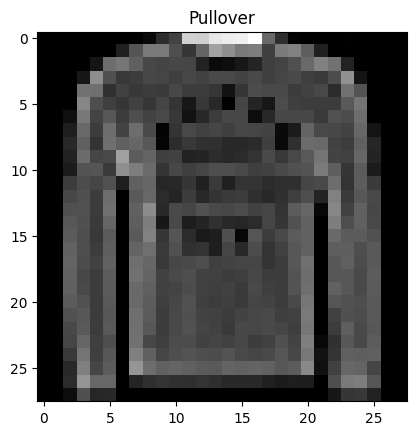

In [48]:

plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])


In [54]:


# Make predictions
pred_probs = make_predictions(model=model_3,
                              data=test_samples)


In [55]:

# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 4, 4, 3, 7, 4, 2, 3, 4])

In [56]:
test_labels

[2, 4, 4, 3, 7, 4, 2, 0, 4]

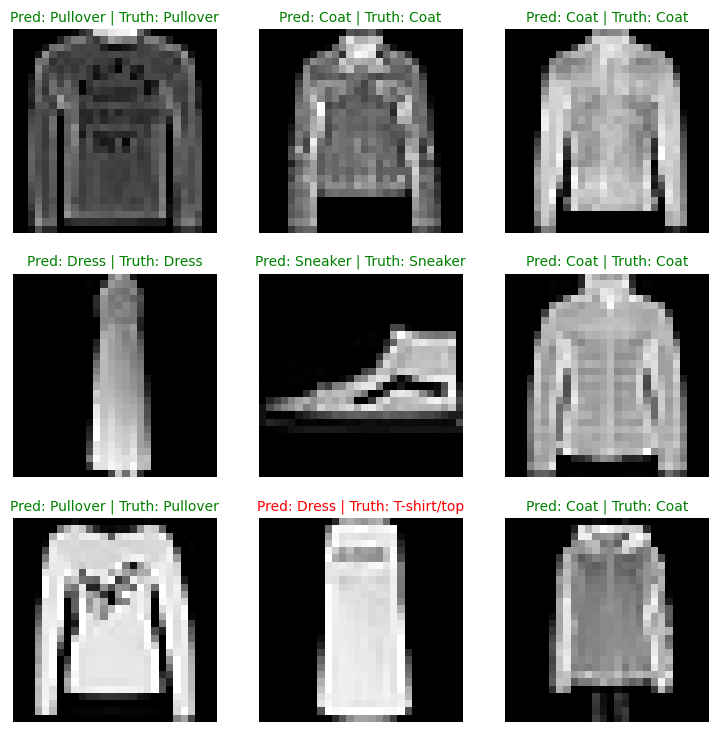

In [57]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False);

In [59]:

# Import tqdm.auto
from tqdm.auto import tqdm


# 1. Make predictions with trained model
y_preds = []
model_3.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 3, 5])

In [73]:
from pathlib import Path
model_path=Path('models')
model_path.mkdir(parents=True,exist_ok=True)
model_name='cnn_model.pth'
torch.save(obj=model_3.state_dict(),f=Path(model_path)/model_name)


In [74]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV3(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=Path(model_path)/model_name))

# Send the model to the target device
loaded_model_2.to(device)


<ipython-input-74-5886b86d50a6>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=Path(model_path)/model_name))


FashionMNISTModelV3(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)